**@adriantoto**

***

# Import Libraries 

Program ini menggunakan *libraries* standar yang sering digunakan pada *data analytics*. 

In [15]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
from scipy.optimize import curve_fit 
import scipy.integrate 
import datetime 

# Import Data

Data diunduh dari *website* **KawalCovid19**. 

In [17]:
df = pd.read_csv('Kasus Harian.csv') # raw dataset
df_sample = df.loc[0:27, ['DT','Kasus (Kumulatif)']] # data sample for simulation
with pd.option_context('display.max_rows',10):
    print(df_sample)

                     DT  Kasus (Kumulatif)
0   2020-03-02 00:00:00                  2
1   2020-03-03 00:00:00                  2
2   2020-03-04 00:00:00                  2
3   2020-03-05 00:00:00                  2
4   2020-03-06 00:00:00                  4
..                  ...                ...
23  2020-03-25 00:00:00                790
24  2020-03-26 00:00:00                893
25  2020-03-27 00:00:00               1046
26  2020-03-28 00:00:00               1155
27  2020-03-29 00:00:00               1285

[28 rows x 2 columns]


Data yang digunakan untuk simulasi adalah data **kasus kumulatif** dari tanggal **2 Maret hingga 29 Maret**. 

Text(0, 0.5, 'Cases')

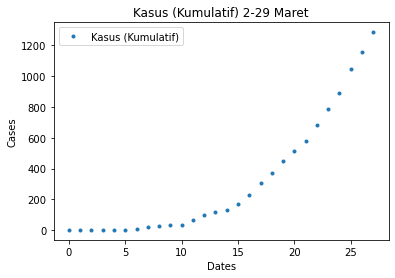

In [18]:
ax = df_sample.plot(marker='.', linewidth=0, title='Kasus (Kumulatif) 2-29 Maret') # plotting
ax.set_xlabel("Dates")
ax.set_ylabel("Cases")

# Estimasi Parameter 

Data kemudian dihampiri dengan **kurva eksponensial** yang bentuk fungsinya sebagai berikut:

In [19]:
def fit_func(t, a, b, c): # fitting function dengan parameter konstanta a, b, & c
    return a*np.exp(b*t)-c

Kita coba hampiri titik-titik data dengan fungsi eksponesial menggunakan **curve_fit**:

Text(0, 0.5, 'Cases')

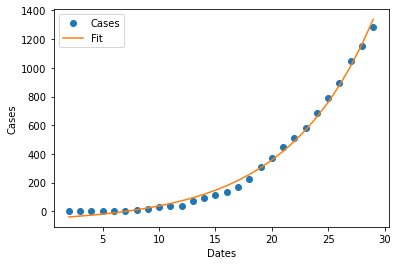

In [20]:
xData = np.arange(2, 30) # x-axis
yData = df_sample['Kasus (Kumulatif)'].values # y-axis
popt, pcov = curve_fit(fit_func, xData, yData) # curve fit
plt.plot(xData, yData, 'o') # plotting
plt.plot(xData, fit_func(xData, popt[0], popt[1], popt[2]))
plt.legend(['Cases', 'Fit'], loc='best')
plt.xlabel("Dates")
plt.ylabel("Cases")

Kemudian didapatkan nilai estimasi untuk parameter konstanta **_a_**, **_b_**, & **_c_** sebagai berikut:

In [21]:
print('[a, b, c] = ', popt)

[a, b, c] =  [32.03509662  0.13073011 80.67504908]


Estimasi tersebut mempunyai nilai **_RMSE_** sebagai berikut:

In [22]:
modelPredictions = fit_func(xData, *popt) 
absError = modelPredictions - yData
SE = np.square(absError) # squared error
MSE = np.mean(SE) # mean squared error
RMSE = np.sqrt(MSE) # root mean squared error
Rsquared = 1.0 - (np.var(absError) / np.var(yData)) # R-Squared
print('RMSE:', RMSE)

RMSE: 27.57427944088768


# Initial Values

Dengan menggunakan nilai *a*, *b*, & *c* dan beberapa asumsi, kita bisa menghitung **nilai-nilai awal** dengan formula sebagai berikut:

In [23]:
# ----- asumsi-asumsi awal -----
f = 0.8 # asumsi 80 % yang sakit melapor (20 % tidak melapor).
nu = 1/7 # asumsi rata-rata waktu tidak mempunyai gejala sakit adalah 7 hari.
eta = 1/7 # asumsi rata-rata waktu mempunyai gejala sakit adalah 7 hari.
S_0 = 9608000 # asumsi jumlah penduduk Jakarta 

# ----- nilai-nilai awal -----
nu1 = f*nu 
nu2 = (1-f)*nu
I_0 = (popt[1]*popt[2]/(f*(nu1+nu2)))
U_0 = ((1-f)*(nu1+nu2)*I_0)/(eta+popt[1])
tau_0 = ((popt[1]+nu1+nu2)/S_0)*((eta+popt[1])/(nu2+eta+popt[1]))
t_0 = (np.log(popt[2])-np.log(popt[0]))/popt[1]
R_0 = ((tau_0*S_0)/(nu1+nu2))*(1+(nu2/eta))
print("I_0:" ,I_0)
print("U_0:" ,U_0)
print("tau_0:" ,tau_0)
print("t_0:" ,t_0)
print("R_0:" ,R_0)

I_0: 92.28325807285245
U_0: 9.637380710530389
tau_0: 2.5782418093128966e-08
t_0: 7.064916206990556
R_0: 2.080826773525778


# Intervensi Pemerintah

Fungsi ini menggambarkan **laju interaksi antar manusia yang perlu diusahakan hingga mendekati 0 (seminimal mungkin)**. Bentuk intervensi pemerintah seperti menutup tempat hiburan dan *work from home*. Bentuk fungsi ini adalah sebagai berikut:

In [24]:
def tau_t(t, mu): # decreasing function
    return tau_0*np.exp(-mu*(t-25)) # asumsi intervensi pemerintah dimulai pada 25 Maret.

Jika kita *plotting* fungsi ke grafik, bisa dilihat bahwa fungsi membuat nilai mendekati 0 secara eksponensial, dengan nilai parameter input **_mu_** sebagai **faktor peubah untuk besar nilai laju transmisi**. 

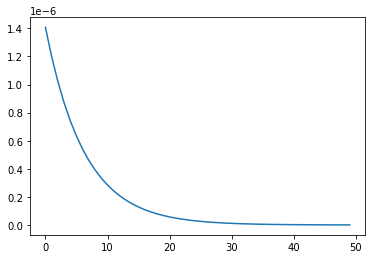

In [25]:
xTest = np.arange(0,50) # x-axis 
plt.plot(xTest, tau_t(xTest, 0.16)) # asumsi nilai mu = 0,16

# Model SIRU (Susceptible, Infected, Reported, & Unreported)

In [26]:
# parameter input
t = np.arange(0, 365) # hari selama setahun sebagai x-axis
y0 = S_0, I_0, R_0, U_0 # nilai awal

# SIRU Model
def SIRU_model(y, t, mu, nu, nu1, nu2, eta): 
    S, I, R, U = y
    if t < 25: 
        tau = tau_0 # nilai laju interaksi sebelum intervensi pemerintah
    else: 
        tau = tau_t(t, mu) # nilai laju interaksi setelah intervensi pemerintah
    # sistem persamaan diferensial biasa
    dS_dt = -tau*S*(I+U)
    dI_dt = tau*S*(I+U)-(nu*I)
    dR_dt = (nu1*I)-(eta*R)
    dU_dt = (nu2*I)-(eta*U)
    # output
    return(dS_dt, dI_dt, dR_dt, dU_dt)

Nilai *mu* menentukan laju dari transmisi, oleh karena itu dibuat **3 skenario**. Dimana skenario 1 adalah tidak ada intervensi pemerintah, skenario 2 adalah intervensi sedang, dan skenario 3 adalah intervensi ketat. Karena semakin besar nilai *mu* maka semakin besar juga *decreasing function*, oleh karena itu nilai masing-masing *mu* dari skenario 1, 2, dan 3 adalah __*mu*1 < *mu*2 < *mu*3__.

In [27]:
# Result
solution1 = scipy.integrate.odeint(SIRU_model, y0, t, args=(0, nu, nu1, nu2, eta)) # tidak ada intervensi (mu = 0.0000)
solution2 = scipy.integrate.odeint(SIRU_model, y0, t, args=(0.0025, nu, nu1, nu2, eta)) # intervensi sedang (mu = 0.0025)
solution3 = scipy.integrate.odeint(SIRU_model, y0, t, args=(0.0125, nu, nu1, nu2, eta)) # intervensi ketat (mu = 0.025)

Berikut adalah fungsi untuk **_plotting_** **grafik**, **nilai puncak**, **tanggal puncak**, dan **tanggal berakhir** dari masing-masing skenario:

In [28]:
# plot result
def result(solution, skenario): 
    # Plot figure
    plt.figure(figsize=[15,6]) # ukuran grafik   
    plt.plot(np.arange(0,44), df.loc[0:43, 'Kasus (Kumulatif)'].values.T, # plot titik-titik kasus
             label="Cases (src: KawalCovid19)", marker='X', linewidth=0)
    plt.plot(t, solution[:, 1], label="Infected") # plot kurva I
    plt.plot(t, solution[:, 2], label="Reported") # plot kurva R
    plt.plot(t, solution[:, 3], label="Unreported") # plot kurva U
    plt.grid()
    plt.legend()
    plt.xlabel("Dates")
    plt.ylabel("Values")
    plt.title(skenario)
    plt.show()
    # nilai puncak, tanggal puncak, dan tanggal berakhir
    reported = (solution[:, 2]).tolist() # mengambil data R
    max_value = max(reported)
    max_index = [i for i, j in enumerate(reported) if j == max_value]
    min_value = min(reported[max_index[0]:])
    min_index = [i for i, j in enumerate(reported[max_index[0]:]) if j == min_value]
    date_max = datetime.datetime.strptime("02/03/20", "%d/%m/%y") + datetime.timedelta(days=max_index[0])
    date_end = datetime.datetime.strptime("02/03/20", "%d/%m/%y") + datetime.timedelta(days=min_index[0])
    # format output
    max_value = round(max_value)
    date_max = date_max.strftime("%b %d %Y")
    date_end = date_end.strftime("%b %d %Y")
    print("Puncak total kasus (Reported) adalah %s pada %s dan mereda pada %s" % (max_value, date_max, date_end))

# Skenario I (Tidak ada Kebijakan)

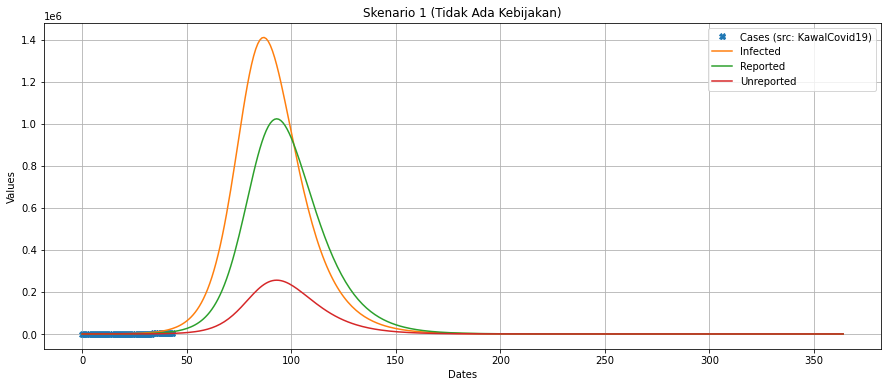

Puncak total kasus (Reported) adalah 1023235 pada Jun 03 2020 dan mereda pada Nov 28 2020


In [29]:
result(solution1, 'Skenario 1 (Tidak Ada Kebijakan)')

# Skenario II (Ada Kebijakan Namun Tidak Tegas)

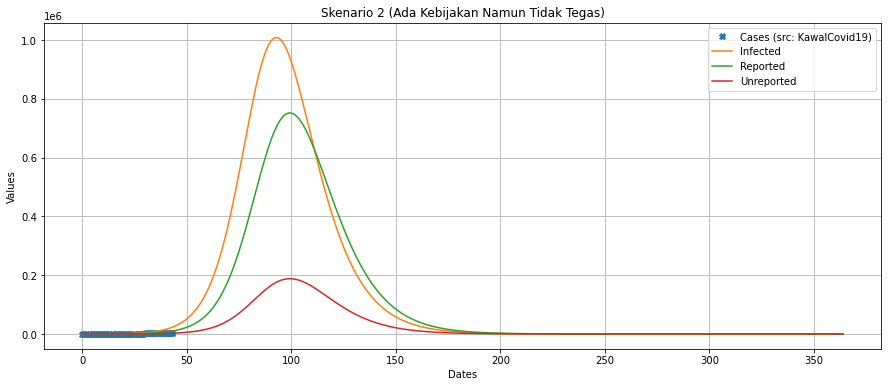

Puncak total kasus (Reported) adalah 751822 pada Jun 09 2020 dan mereda pada Nov 22 2020


In [30]:
result(solution2, 'Skenario 2 (Ada Kebijakan Namun Tidak Tegas)')

# Skenario III (Ada Kebijakan & Tegas)

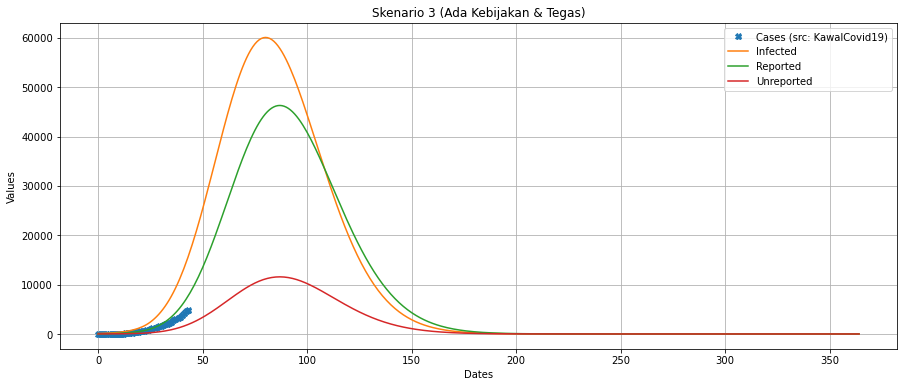

Puncak total kasus (Reported) adalah 46306 pada May 28 2020 dan mereda pada Dec 04 2020


In [31]:
result(solution3, 'Skenario 3 (Ada Kebijakan & Tegas)')

Dari ketiga skenario di atas bisa dilihat bahwa **semakin ketat intervensi pemerintah, maka semakin kecil total kasus & semakin cepat berakhir**.  

# Perbandingan dari Ketiga Skenario 

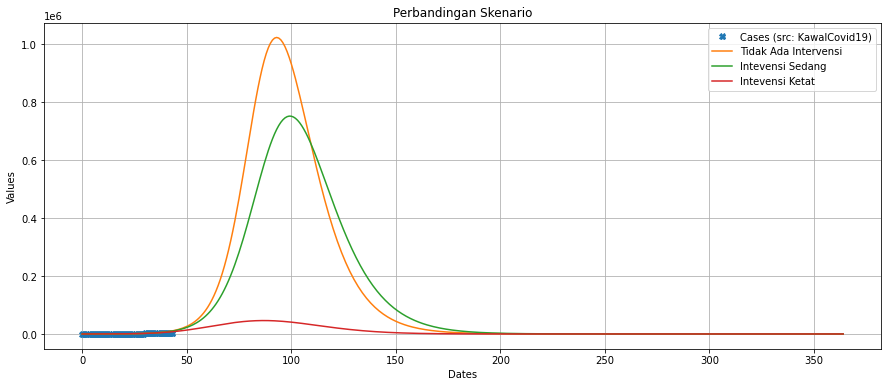

In [32]:
plt.figure(figsize=[15,6]) 
plt.plot(np.arange(0,44), df.loc[0:43, 'Kasus (Kumulatif)'].values.T, 
         label="Cases (src: KawalCovid19)", marker='X', linewidth=0)
plt.plot(t, solution1[:, 2], label="Tidak Ada Intervensi")
plt.plot(t, solution2[:, 2], label="Intevensi Sedang")
plt.plot(t, solution3[:, 2], label="Intevensi Ketat")
plt.grid()
plt.legend()
plt.xlabel("Dates")
plt.ylabel("Values")
plt.title("Perbandingan Skenario")
plt.show()

Bisa dilihat dari grafik di atas bahwa **semakin ketat intervensi dari pemerintah, maka semakin landai kurva total kasus (*flatting the curve*)**. 

# Kesimpulan

- Semakin ketat intervensi dari pemerintah, maka **semakin kecil total kasus & semakin cepat berakhir**
- semakin ketat intervensi dari pemerintah, maka **semakin landai kurva total kasus (*flatting the curve*)**

# Referensi

- https://drive.google.com/file/d/1XSBQFWstqz__vYwobC-91LQ0BYo968r8/view
- https://www.mdpi.com/2079-7737/9/3/50
- https://kawalcovid19.id/